In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
# 自注意力模块
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        attn_scores = F.softmax(q @ k.transpose(-2, -1), dim=-1)
        attn_output = attn_scores @ v

        return attn_output

In [3]:
class AttentionModel(nn.Module):
    def __init__(self, num_classes=10):
        super(AttentionModel, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity()  # Remove the last FC layer
        self.self_attn = SelfAttention(512)  # 512 is the output dimension of resnet18
        self.fc = nn.Linear(512, 4096)
        self.relu = nn.ReLU(4096)
        self.fc2 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.self_attn(x)
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [4]:
# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 加载CIFAR-10数据集
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [5]:
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Files already downloaded and verified


In [6]:
model = AttentionModel(num_classes=10)
model.to(device="mps", dtype=torch.bfloat16)

AttentionModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [7]:
from tqdm.notebook import tqdm, trange

In [8]:
cnt = 0
n_cnt = 0
steps = 0
total = 3126 + 1

In [9]:
for _, p in model.named_parameters():
    def hook(grad):
        global steps
        up_scale_thresh = 1e-2 * (1 - steps / total) ** 2
        global cnt
        global n_cnt
        if torch.any(abs(grad) < up_scale_thresh):
            cnt += 1
            if cnt % int(1e4) == 0:
                print(f"upscale_times: {cnt}")
                print(f"no_op_times: {n_cnt}")
            grad = up_scale_thresh * grad / torch.max(abs(grad))
            return grad
        n_cnt += 1
        return grad
    p.register_hook(hook=hook)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [11]:
loss_list = []

In [12]:
for epoch in range(2):
    for index, (images, labels) in tqdm(enumerate(trainloader), total=len(trainloader)):
        images = images.to(device="mps", dtype=torch.bfloat16)
        outputs = model(images)
        labels = labels.to(device="mps", dtype=torch.bfloat16)
        # convert labels to one-hot
        labels = labels.to(device="mps", dtype=torch.long)  # convert labels to long
        labels_one_hot = F.one_hot(labels, num_classes=10)  # apply one-hot encoding
        labels_one_hot = labels_one_hot.to(device="mps", dtype=torch.bfloat16)
        # print(labels_one_hot, outputs)
        loss = criterion(outputs, labels_one_hot)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        global steps
        steps += 1
        if loss.isnan():
            print(f"Step: {index}, Loss: {loss.item()}")
        with open("./data/loss.txt", "a") as f:
            f.write(f"{loss.item()}\n")
        if any([(index + i) % 1000 == 0 for i in range(10)]):
            print(f"Step: {index}, Loss: {loss.item()}")

  0%|          | 0/1563 [00:00<?, ?it/s]

Step: 0, Loss: 2.359375
upscale_times: 10000
no_op_times: 30
upscale_times: 20000
no_op_times: 86
upscale_times: 30000
no_op_times: 165
upscale_times: 40000
no_op_times: 269
upscale_times: 50000
no_op_times: 379
upscale_times: 60000
no_op_times: 529
Step: 991, Loss: 0.98828125
Step: 992, Loss: 1.296875
Step: 993, Loss: 0.96875
Step: 994, Loss: 0.85546875
Step: 995, Loss: 0.8515625
Step: 996, Loss: 0.7734375
Step: 997, Loss: 1.2734375
Step: 998, Loss: 1.578125
Step: 999, Loss: 0.85546875
Step: 1000, Loss: 0.9296875
upscale_times: 70000
no_op_times: 722
upscale_times: 80000
no_op_times: 962
upscale_times: 90000
no_op_times: 1253
upscale_times: 100000
no_op_times: 1633


  0%|          | 0/1563 [00:00<?, ?it/s]

Step: 0, Loss: 0.93359375
upscale_times: 110000
no_op_times: 2013
upscale_times: 120000
no_op_times: 2564
upscale_times: 130000
no_op_times: 3206
upscale_times: 140000
no_op_times: 4150
upscale_times: 150000
no_op_times: 5248
upscale_times: 160000
no_op_times: 6784
Step: 991, Loss: 0.72265625
Step: 992, Loss: 0.91796875
Step: 993, Loss: 0.91015625
Step: 994, Loss: 0.69140625
upscale_times: 170000
no_op_times: 9090
Step: 995, Loss: 0.69140625
Step: 996, Loss: 0.875
Step: 997, Loss: 0.84765625
Step: 998, Loss: 0.77734375
Step: 999, Loss: 0.7578125
Step: 1000, Loss: 0.6796875
upscale_times: 180000
no_op_times: 12455
upscale_times: 190000
no_op_times: 18533


In [13]:
torch.save(model.state_dict(), "./attention_model.pth")

In [14]:
import matplotlib.pyplot as plt

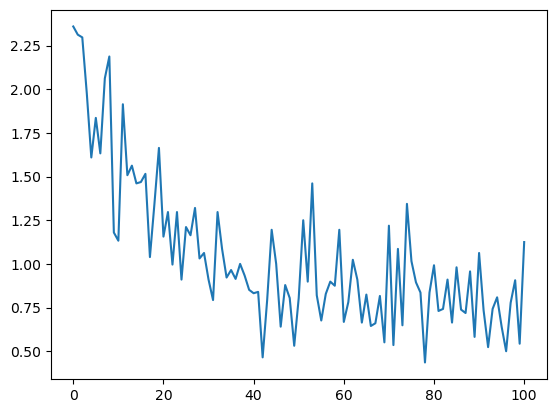

In [15]:
# plot the loss, sample up to 1000 points
plt.plot(loss_list[::len(loss_list)//100])

In [16]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, total=len(test_loader)):
        images = images.to(device="mps", dtype=torch.bfloat16)
        labels = labels.to(device="mps", dtype=torch.bfloat16)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  0%|          | 0/313 [00:00<?, ?it/s]

In [17]:
print(f"Accuracy: {100 * correct / total}%")

Accuracy: 45.42%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

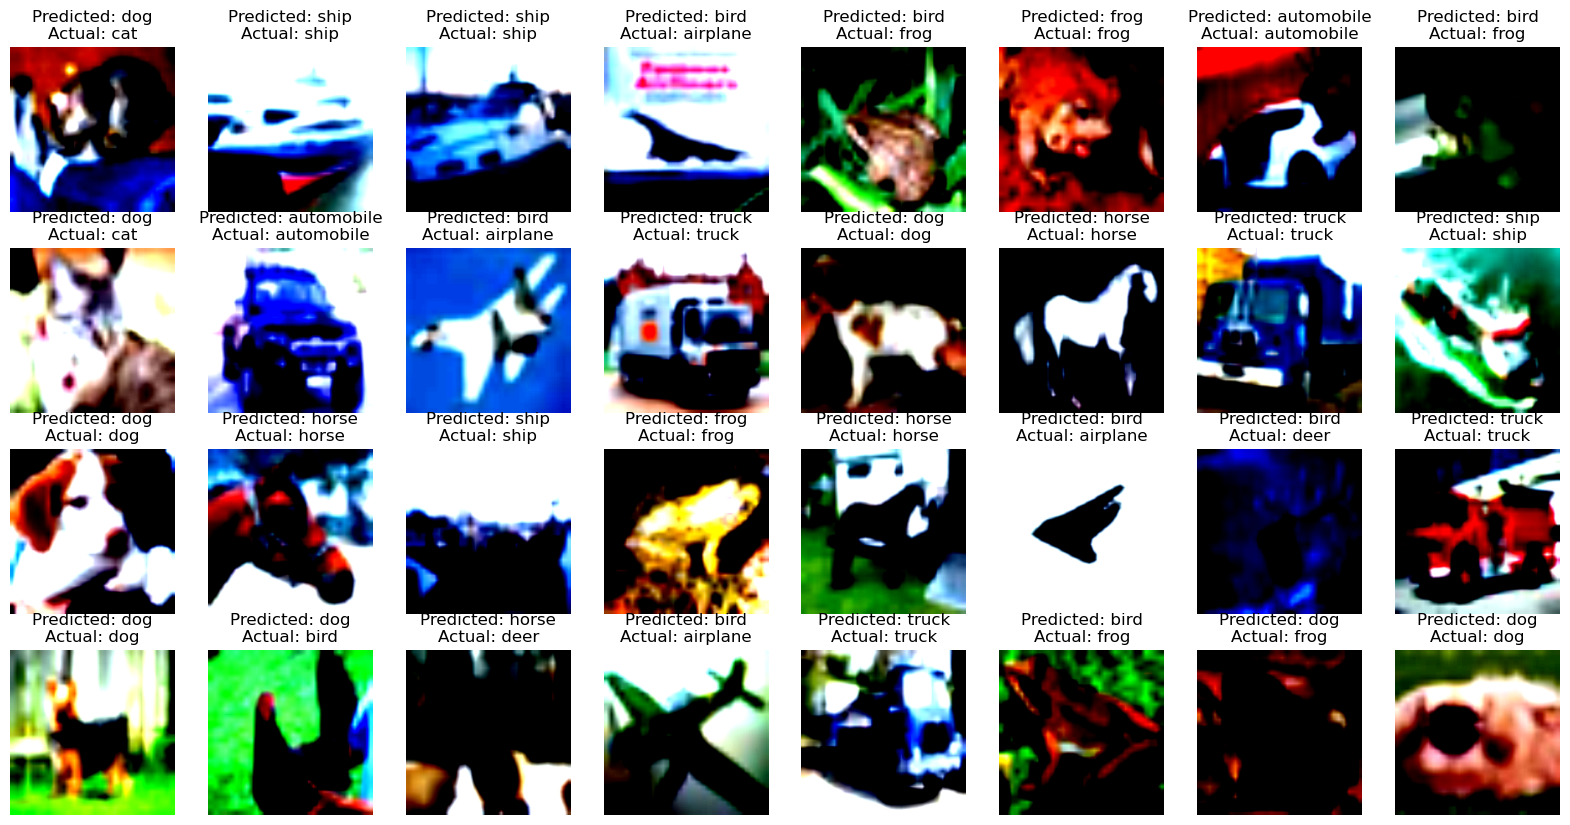

In [22]:
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device="mps", dtype=torch.bfloat16)
test_labels = test_labels.to(device="mps", dtype=torch.bfloat16)

outputs = model(test_images)
_, predicted = torch.max(outputs, 1)

label_mapper = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i].to(dtype=torch.float32).permute(1, 2, 0).cpu())
    ax.set_title(f"Predicted: {label_mapper[predicted[i].item()]}\nActual: {label_mapper[test_labels[i].item()]}")
    ax.axis("off")

plt.show()
